# **COURSE PROJECT: CONTROL DESIGN**

<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/images/simple_feedback_nofilter.png "
     alt="Markdown Monster icon"
     width="600" height="300"
     style="float: left; margin-right: 10px;" />

The course project is to do a control design for a system of your choosing.
I highly recommend that the system have a reproducible model.
A good place to look for such models is the [BioModels](https://www.ebi.ac.uk/biomodels/search?query=*%3A*+AND+curationstatus%3A%22Manually+curated%22&domain=biomodels) curated branch. Most of these models have published papers as well.

In [1]:
if True:
    # Use these if you need to
    !pip -q install tellurium
    !pip -q install controlSBML
    !pip -q install control


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import tellurium as te
import controlSBML as ctl
from controlSBML import ControlSBML, constants
from controlSBML.grid import Grid
import control
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, List
#import session_info

In [4]:
#session_info.show(cpu=True,jupyter=True,dependencies=False,write_req_file=True, req_file_name='jupyter_session_info.txt',html=False)

# Helpers

In [5]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 5, 500)
WOLF_URL = constants.WOLF_URL

## plotStep

In [6]:
def plotStep(tf, title:str="", times=TIMES, xlim:Optional[list]=None, figsize=[5,5],
      is_plot=True):
    """
    Plots the step response of the transfer function.

    Args:
        tf - transfer function
    """
    _, ax = plt.subplots(1, 1, figsize=figsize)
    _, yv = control.step_response(tf, T=times)
    _ = ax.plot(times, yv)
    if xlim is not None:
        ax.set_xlim(xlim)
    _ = ax.set_title(title)
    if not is_plot:
        plt.close()

# TESTS
tf = control.TransferFunction([5], [1, 5])
plotStep(tf, is_plot=False, xlim=[0, 3])
print("OK!")

OK!


## complex_magnitude

In [7]:
def complex_magnitude(z):
    return (z.real**2 + z.imag**2)**0.5

## ppComplex

In [8]:
def ppComplex(complexes:np.ndarray, round_digits=3)->str:
    """
    Constructs a pretty print representation of a complex number.
    """
    complexes = np.array(complexes)
    complexes = complexes.flatten()
    if not isinstance(complexes, list):
        complexes = [complexes]
    results = []
    if isinstance(complexes[0], np.ndarray):
        complexes = complexes[0]
    for cmpx in complexes:
        try:
            if np.imag(cmpx) == 0:
                results.append(str(round(np.real(cmpx), round_digits)))
            else:
                 results.append(str(round(np.real(cmpx), round_digits)) + "+" + str(round(np.imag(cmpx), round_digits)) + "j")
        except:
            import pdb; pdb.set_trace()
    return ", ".join(results)

# Tests
result = ppComplex((-1.9999999999999998+0j))
result = ppComplex([3+2j, 4])
assert("j" in result)
print("OK!")

OK!


## plotRootLocusWithGains

In [9]:
def plotRootLocusWithGains(open_loop_transfer_function:control.TransferFunction,
      gains:List[float],
      xlim:Optional[np.ndarray]=None,
      title:Optional[str]=None,
      ylim:Optional[np.ndarray]=None,
      is_annotate:bool=True,
      markersize_multiplier:float=100,
      fontsize=10,
      figsize=(5, 5),
      ax=None,
      is_plot:bool=True)->plt.axes:
    """
    Constructs a root locus plot with red hexagons for closed loop poles at different gains.
    Poles at specific gains are indicated by hexigon markers.

    Args:
        open_loop_transfer_function
        gains
        xlim: limits on the axis
        size_multiplier: multiplies by gain to get size of hexagon that marks the pole
        figsize: width and height of figure
        is_annotate: Annotate gain hexigons with gain values
    """
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)
    # Plot the root locus
    _ = control.root_locus(open_loop_transfer_function, grid=False, plot=True, xlim=xlim,
          ylim=ylim, ax=ax)
    # Construct the title
    if title is None:
        poles = open_loop_transfer_function.poles()
        zeros = open_loop_transfer_function.zeros()
        title = ""
        if len(poles) > 0:
            title += f"FFL poles: {ppComplex(poles)}  "
        if len(zeros) > 0:
            title += f"FFL zeros: {ppComplex(zeros)}"
    ax.set_title(title,size=fontsize)
    # Add points for closed loop poles
    for gain in gains:
        closed_loop_transfer_function = control.feedback(gain*open_loop_transfer_function)
        poles = closed_loop_transfer_function.poles()
        xv = []
        yv = []
        for pole in poles:
            xv.append(pole.real)
            yv.append(pole.imag)
        if is_annotate:
            annotation = str(gain)
        else:
            annotation = ""
        ax.scatter(xv, yv, s=markersize_multiplier*gain, marker="h", color="r")
        [ ax.annotate(annotation, (xv[i], yv[i]), color='blue', rotation=25)
             for i in range(len(poles))]
        arrowprops=dict(facecolor='black', shrink=0.05)
    # Plot at zero
    ax.plot([0, 0], [-10, 10], color="grey", linestyle="--")
    #
    if not is_plot:
        plt.close()
        ax = None
    return ax

# Tests
tf = control.zpk([1], [-1, -2], [1])
plotRootLocusWithGains(tf, [0.2, 0.5], markersize_multiplier=200, ylim=[-3, 3], xlim=[-3.5, 0], is_annotate=True,
      figsize=(2, 2), is_plot=False)
print("OK!")

OK!


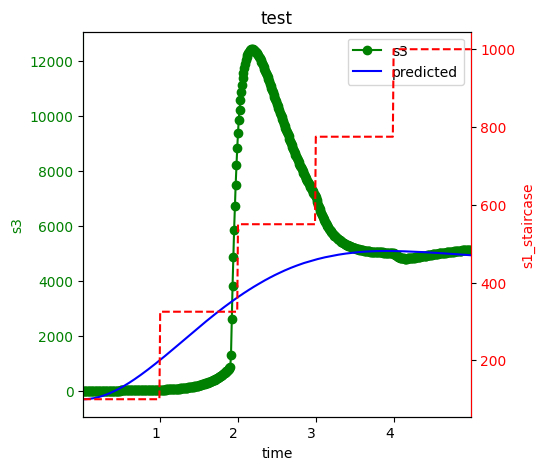

Transfer function:  
          -15.57
---------------------------
-14.5 s^2 - 13.42 s - 14.84

poles:  [-0.46289143+0.89966625j -0.46289143-0.89966625j]
DC gain:  1.0488709353683376
OK


In [10]:
def get_tf_stats(model,poles:int,zeroes:int,times:np.linspace,start:int,title):
  _=model.plotTransferFunctionFit(num_zero=zeroes, num_pole=poles, initial_value=100, final_value=1000, num_step=4, fit_start_time=start,times=times, title=title)
  model_tf = model.getOpenLoopTransferFunction()
  print("Transfer function: ", model_tf)
  print("poles: ", model_tf.poles())
  if(zeroes > 0):
    print("zeroes: ", model_tf.zeros())
  print("DC gain: ", model_tf.dcgain())

#test
TEST_CTLSB = ctl.ControlSBML(WOLF_URL,input_name="s1",output_name="s3")
get_tf_stats(model=TEST_CTLSB,poles=2,zeroes=0,times=TIMES,start=0,title="test")
print("OK")

# Step 1. State design objectives (5 pt)

1. Select a model and load it into Tellurium. Print it in Antimony.
1. Specify the output from the model that you want to control.
2. One of your design objectives is that the closed loop system is stable. Provide two additional objectives such as: eliminate bias (the system converges to the desired output); no oscillations; settling times no greater than X (where you specify X); no overshoot (undershoot).


In [11]:
#define constants. QS prefix indicates "Quorum Sensing"
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL8262229752/3/MODEL8262229752_url.xml" #this is a model of quorum sensing autoinducer synthesis in E. coli from methionine
QS_RR = te.loadSBMLModel(URL) #Objective 1: load into Tellurium.
QS_CTLSB = ctl.ControlSBML(URL,input_name="Met",output_name="AI2_intra") #this also loads the model for later use, but technically not into tellurium
QS_TIMES = np.linspace(0, 5000, 5000)

In [12]:
#Objective 1: Print model in Antimony (can also do this from CTLSB)
print(QS_RR.getAntimony())

// Created by libAntimony v2.13.2
model *Li2006_QuorumSensing()

  // Compartments and Species:
  compartment compartment_;
  species Nutrients in compartment_, Met in compartment_, SAM in compartment_;
  species SAH in compartment_, Decarb_SAM in compartment_, Putrescine in compartment_;
  species Pfs_mRNA in compartment_, pfs_gene in compartment_, Pfs_prot in compartment_;
  species Adenine in compartment_, SRH in compartment_, LuxS_gene in compartment_;
  species LuxS_mRNA in compartment_, LuxS_prot in compartment_, DPD in compartment_;
  species Homocys in compartment_, MTA in compartment_, Spermidine in compartment_;
  species MTR in compartment_, AI2_intra in compartment_, AI2_extra in compartment_;

  // Reactions:
  bio_reac: Nutrients => Met; b_reac_r*Nutrients;
  AdoMet: Met => SAM; AdoMet_r*Met;
  MethyTrans: SAM => SAH; Methy_trans*SAM;
  SAM_Decarb: SAM => Decarb_SAM; SAM_Dec*SAM;
  SpeE_syn: Decarb_SAM + Putrescine => MTA + Spermidine; SpeE_syn_r*Decarb_SAM*Putrescine;
  

# Problem narrative
This model describes a route to production of the quorum sensing molecule autoinducer 2 (AI-2) in E. coli from methionine. Quorum sensing is a bacterial system that regulates many cell and population-level responses based on cell density. In synthetic biology applications such as strain construction for bioproduction, it can be useful to decouple quorum sensing behavior from cell density to activate certain cell programs earlier in culture. Therefore, I would like to promote production of intracellular AI-2 by modulating the amount of methionine in growth media. My control objectives are:

1. Reach a steady-state concentration of 500 nM of AI-2
2. Have no overshoot.
3. Reach steady-state within 500 seconds.

# Step 2. Find the control input and operating region (5 pt)

1. Choose a suitable input to control the system output. Plot a staircase function of the input over the operating region. Specify:
      1. directional effect of the input on the output
      1. operating region for the input
      1. range of outputs that can be achieved (feasible setpoints)
1. Write a short narrative describing how the plot indicates that the control objectives can be achieved over the operating region.

# Initial system observations
Looking at the uncontrolled system focused on the input and output, we can get a sense of parameters that may be useful later.


*   System settling time is on the order of 10^3
*   reasonable input concentrations are on the order of 10^2 - 10^3
*   reasonable output concentrations are on the order of 10^2


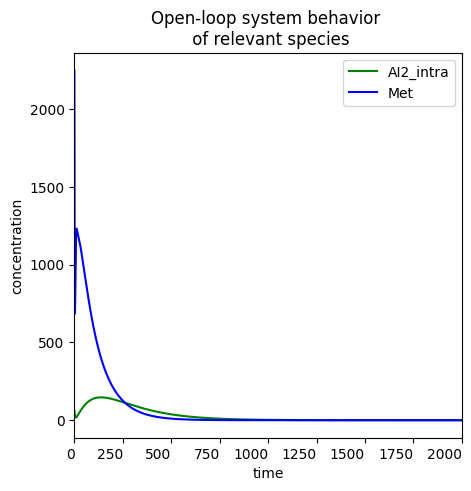

In [13]:
_ = QS_CTLSB.plotModel(times=np.linspace(0, 2000, 20000),selections=["AI2_intra","Met"],title="Open-loop system behavior \n of relevant species")

#Input selection
Looking at the model graph, we can get a sense of what might be a good input by observing which reactions feed into the AI2_intra node. Going up the chain, we see an important node is s-adenosyl methionine (SAM) since flux through this node either undergoes methyltransfer, making the precursor to our desired pathway, or to decarboxylation, whose products are not relevant. For the purposes of this exercise, I wanted to see whether it was possible to acheive control by manipulating methionine rather than something like SAH that's further down the desired pathway. It's easier to add methionine to growth media (and frankly I was just interested in how feasible it is to operate at the furthest node up the reaction network.)

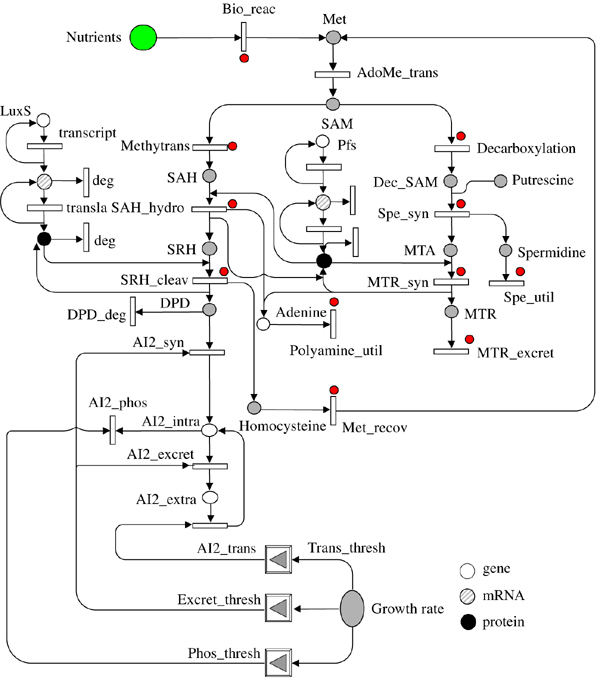

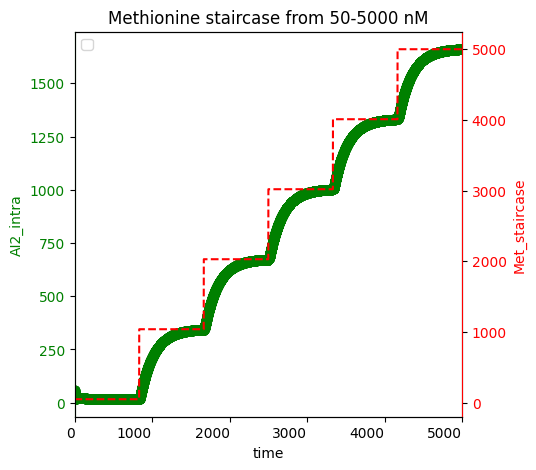

In [14]:
#staircase plot with methionine input and intracellular AI-2 output
_ = QS_CTLSB.plotStaircaseResponse(initial_value=50, final_value=5000,times=np.linspace(0, 5000, 50000),title = "Methionine staircase from 50-5000 nM")


1. The output has a positive relationship with the input
2. The operating region is sensitive across at least two orders of magnitude (50-5000 nM) and around both sides of the concentrations in the uncontrolled system.
3. The feasible setpoints range across three orders of magnitudes (15-1500 nM). My target setpoint is firmly within this range, and the response is linear on both sides of it.

2.. The plot demonstrates a consistent step response across the operating range. The target setpoint is in the middle of the output range, and the system is controllable at physiologically relevant input levels. There do not appear to be significant oscillations with each jump.

# Step 3. Do system identification (5 pt)

For the system and operating point that you selected, find a transfer function that fits the staircase response.
By *fit*, I mean that the transfer function broadly follows the predicted value.
If you later find that your theorty-based design (step 4) provides little insight into your final design (step 5), you may need to revisit this step.

The natural settling time of the system is long, so steps of 1000 seconds should allow reaching steady-state. There is an initial transient that messes with the fit, so I will begin the fitting at t=950 seconds.

# First-order approximation
Let's start by seeing if a single pole is sufficient to capture the system

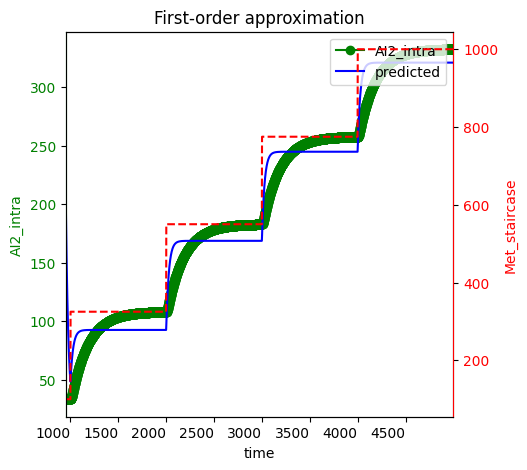

Transfer function:  
       1963
------------------
1.581e+05 s + 5797

poles:  [-0.03665686+0.j]
DC gain:  0.3385533808853193


In [15]:
#first-order approximation
get_tf_stats(QS_CTLSB,poles=1,zeroes=0,times=QS_TIMES,start=950,title="First-order approximation")

This doesn't fully capture the response dynamics. Maybe adding more poles will help


# Two poles, no zeros

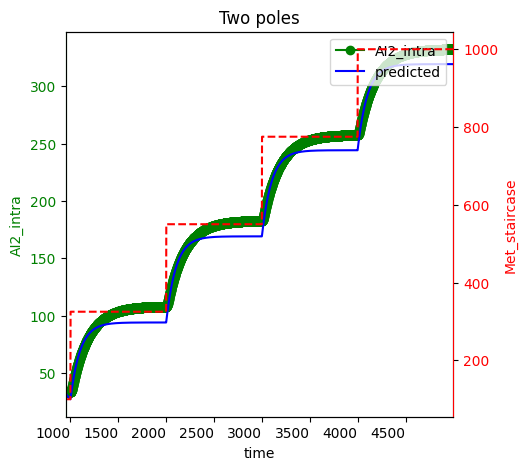

In [16]:
#two poles
#get_tf_stats(QS_CTLSB,poles=2,zeroes=0,times=QS_TIMES,start=950,title="Two poles")
_=QS_CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=2, initial_value=100, final_value=1000, num_step=4, fit_start_time=950,times=QS_TIMES, title="Two poles")


This is better, though the response is too low, and the magnitudes of the poles are very different. Maybe adding in a zero will help.

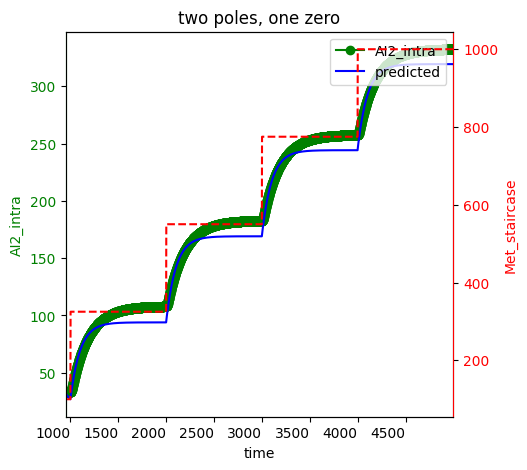

Transfer function:  
      0.02065 s + 0.0326
-------------------------------
0.03233 s^2 + 9.905 s + 0.09758

poles:  [-3.06357998e+02+0.j -9.85205890e-03+0.j]
zeroes:  [-1.57861225+0.j]
DC gain:  0.33407038033669995


In [17]:
#two poles, one zero
get_tf_stats(QS_CTLSB,poles=2,zeroes=1,times=QS_TIMES,start=950,title="two poles, one zero")

Not really. Maybe a few more?

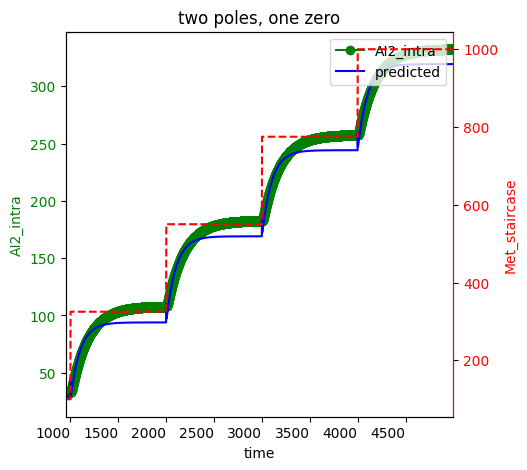

Transfer function:  
      0.003742 s^2 + 9.619e-05 s + 9.918e-05
--------------------------------------------------
9.834e-05 s^3 + 0.03602 s^2 + 0.0302 s + 0.0002969

poles:  [-3.65422333e+02+0.j -8.30423185e-01+0.j -9.94836160e-03+0.j]
zeroes:  [-0.01285183+0.16229005j -0.01285183-0.16229005j]
DC gain:  0.33408009235603975


In [18]:
#really wild
get_tf_stats(QS_CTLSB,poles=3,zeroes=2,times=QS_TIMES,start=950,title="two poles, one zero")

That made very little difference in terms of system response or dominant pole location. **I will stick with the two poles, no zeroes condition to keep the analysis simpler.**

# Step 4. Construct a preliminary, theory-based design (15 pt)

Use the transfer function in step 3 to do a theory-based design using the root locus plot to do PID control.
Start by answering the following questions:
1. Given the open loop poles and zeros of your system, what is the best settling time you can expect? (Recall that root locus branches start at poles and terminate at zeros.)
2. How does your answer change if you use I-control (e.g., PI, PID)?
3. Can you improve matters with pole-zero cancellation?

Write a short narrative that describes the logic you used in your theory-based design.

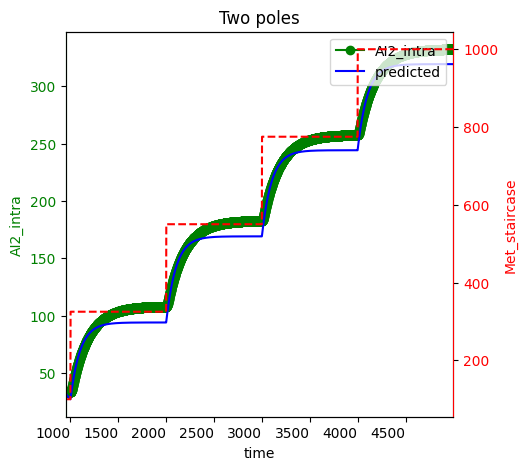

Transfer function:  
            0.0161
-------------------------------
0.01598 s^2 + 4.868 s + 0.04819

poles:  [-3.04698296e+02+0.j -9.89891104e-03+0.j]
DC gain:  0.33405009498203475


In [19]:
#reset the modeled transfer function to the proper number of poles/zeroes
get_tf_stats(QS_CTLSB,poles=2,zeroes=0,times=QS_TIMES,start=950,title="Two poles")

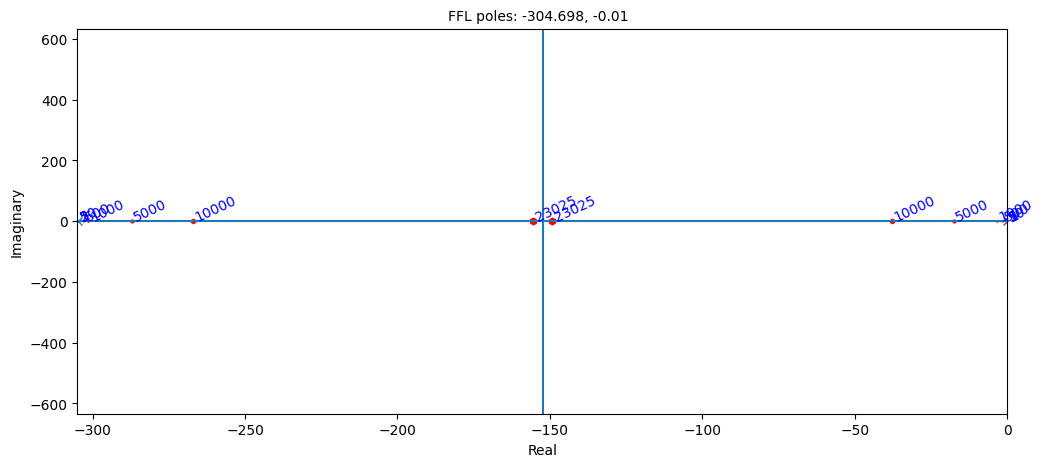

In [20]:
#P-control
QS_TF = QS_CTLSB.getOpenLoopTransferFunction()
_ = plotRootLocusWithGains(QS_TF, gains=[1, 2, 5, 50, 500,1000,5000,10000,23025], xlim=[-305,0],figsize=(12, 5),markersize_multiplier=0.001)

Because I have two real poles and no zeros, I have the ability to speed up my system response by pushing Kp. The system reaches a breakaway point at -152.34, but this requires a very large gain to reach.

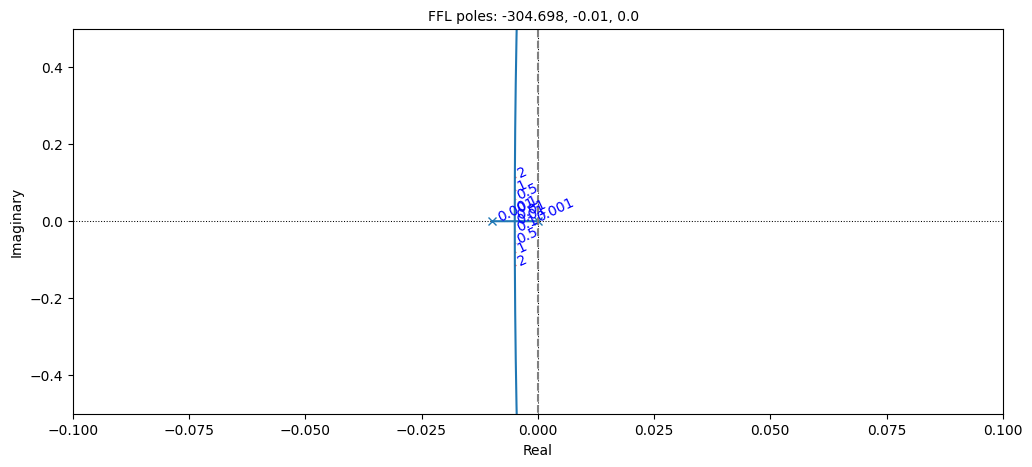

In [21]:
I_tf = control.TransferFunction([2], [1,0])
_ = plotRootLocusWithGains(I_tf*QS_TF, gains=[0.001, 0.01,0.1,0.5, 1, 2], xlim=[-0.1,0.1], ylim=[-0.5,0.5],figsize=(12, 5), markersize_multiplier=0.1)

I-control alone cannot do very much without introducing oscillations. As one of my design criteria is no oscillations, this is not workable.

# PI control


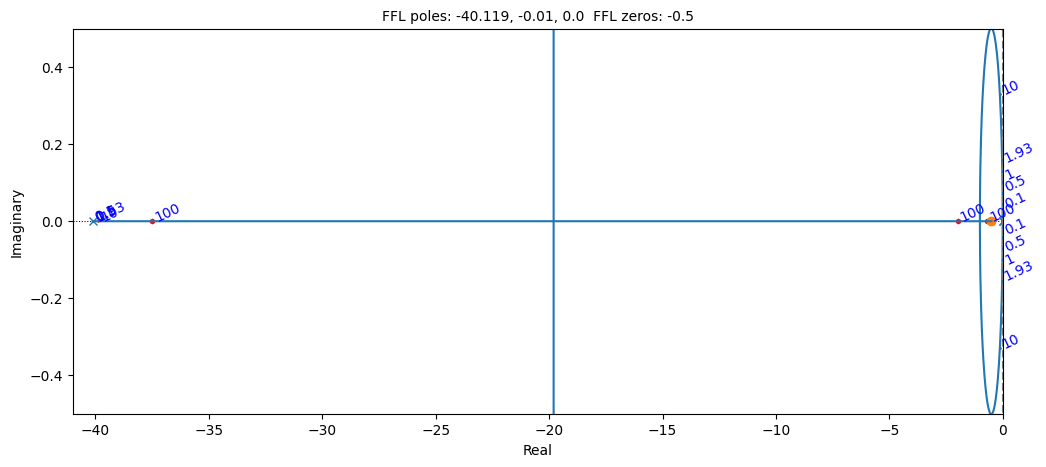

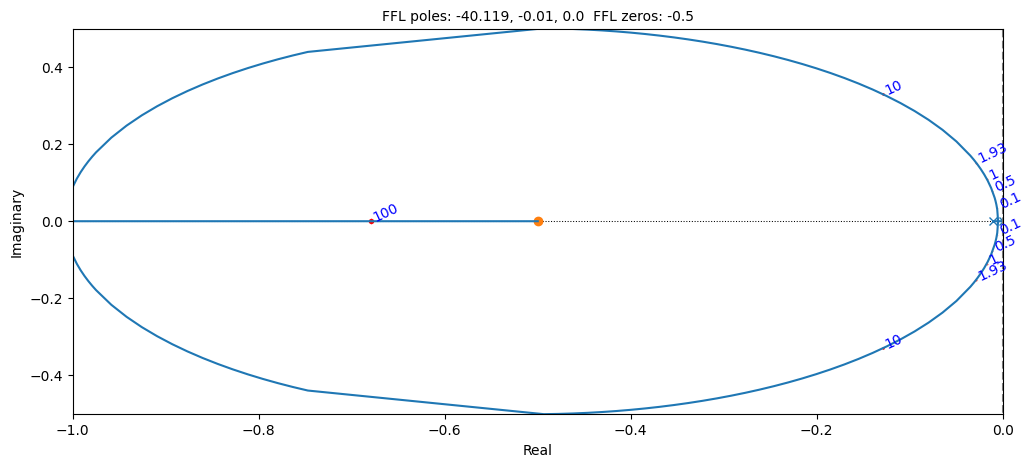

In [22]:
#This cell is where the interesting behavior happens
rIP = 0.5
QS_TF = control.zpk([-0.5],[-0.01,-40.1191,0],[1])
#PI_tf = control.TransferFunction([1, rIP], [1, 0])
_ = plotRootLocusWithGains(QS_TF, gains=[0.1, 0.5, 1, 1.93, 10,100], xlim=[-41, 0], ylim=[-0.5, 0.5], figsize=(12, 5),markersize_multiplier=0.1)
_ = plotRootLocusWithGains(QS_TF, gains=[0.1, 0.5, 1, 1.93, 10,100], xlim=[-1, 0], ylim=[-0.5, 0.5], figsize=(12, 5),markersize_multiplier=0.1)
#_ = control.root_locus(PI_tf*QS_TF,xlim=[-0.5,0])

Adding integral control really limits the system because the open loop pole at -0.01 cannot be moved, and the introduction of the pole at 0 causes branches to get weird. So either the zero would have to be placed just inside the open-loop pole, though this would make kI very small and make kP have diminishing returns, or placed to the left of -0.01, and cause oscillations. The best option with PI control is placing the zero as close to the open-loop pole at -0.01 as possible.

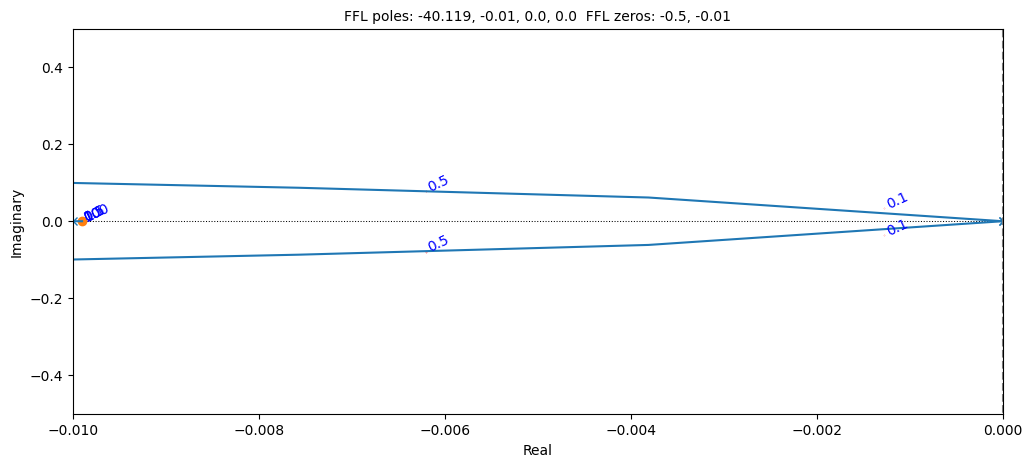

In [23]:
rIP = 0.0099
PI_tf = control.TransferFunction([1, rIP], [1, 0])
_ = plotRootLocusWithGains(PI_tf*QS_TF, gains=[0.1, 0.5, 1, 10,100], xlim=[-0.01, 0], ylim=[-0.5, 0.5], figsize=(12, 5),markersize_multiplier=0.1)

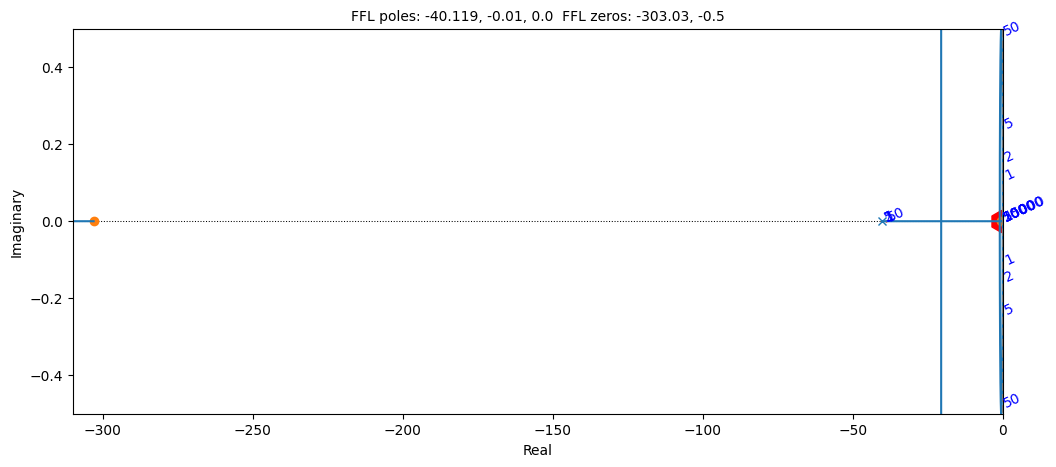

In [24]:
#PD control
rDP = 0.0033
PD_tf = control.TransferFunction([rDP, 1], [1])
_ = plotRootLocusWithGains(PD_tf*QS_TF, gains=[1, 2, 5, 50, 500,1000,5000,10000,25000], xlim=[-310,0], ylim=[-0.5, 0.5],figsize=(12, 5),markersize_multiplier=.01)

PD control is interesting because it provides the flexibility to start from the dominant and move along the branch created by the place-able zero. We can place the zero as close to our second open-loop zero as possible to expand the operating range past the breakaway point observed in P-control. This at first glance seems nice, but we actually see the system is less sensitive to changes in gain than in a P-control system.

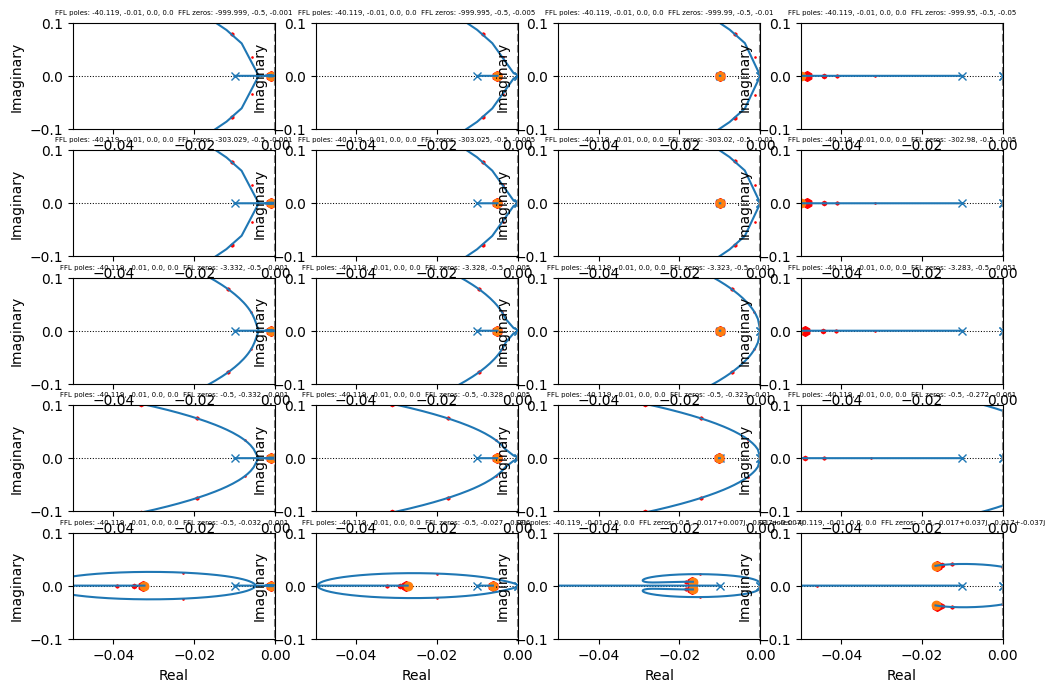

In [25]:
#PID control
RIP_VALUES = [0.001,0.005,0.0099, .05]
RDP_VALUES = [0.001,0.0033, 0.3, 3,30]
num_xpos = len(RDP_VALUES)
num_ypos = len(RIP_VALUES)
_, axes = plt.subplots(num_xpos, num_ypos, figsize=(12, 8))
xpos = 0
ypos = 0
gains = [0.01, 0.1, 1,5,10,50,100,500,1000]
for rIP in RIP_VALUES:
    for rDP in RDP_VALUES:
        ax = axes[xpos, ypos]
        PID_tf = (rIP + s + rDP*s**2)/s
        ff_tf = PID_tf*QS_TF
        _ = plotRootLocusWithGains(ff_tf, [.1, 0.5, 1, 5] , ax=ax,is_annotate=False, xlim=[-0.05, 0],ylim=[-0.1,0.1],markersize_multiplier=10,fontsize=5)
        xpos += 1
        if xpos >= len(RDP_VALUES):
            xpos = 0
            ypos += 1

PID control does not get us anything more than PI unless both introduced zeroes are to the left of the pole at -0.01. This can be acheived by having an rIP >0.01 and rDP <100

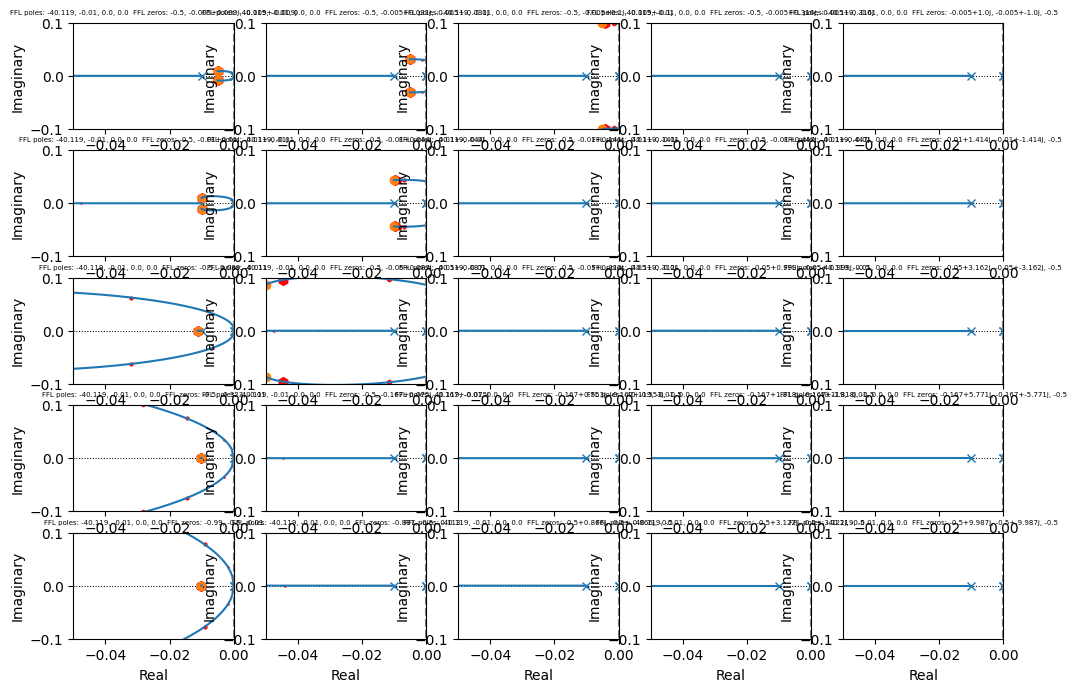

In [26]:
#PID control
RIP_VALUES = [0.01,0.1,1,10,100]
RDP_VALUES = [100,50, 10, 3,1]
num_xpos = len(RDP_VALUES)
num_ypos = len(RIP_VALUES)
_, axes = plt.subplots(num_xpos, num_ypos, figsize=(12, 8))
xpos = 0
ypos = 0
gains = [0.01, 0.1, 1,5,10,50,100,500,1000]
for rIP in RIP_VALUES:
    for rDP in RDP_VALUES:
        ax = axes[xpos, ypos]
        PID_tf = (rIP + s + rDP*s**2)/s
        ff_tf = PID_tf*QS_TF
        _ = plotRootLocusWithGains(ff_tf, [.1, 0.5, 1, 5] , ax=ax,is_annotate=False, xlim=[-0.05, 0],ylim=[-0.1,0.1],markersize_multiplier=10,fontsize=5)
        xpos += 1
        if xpos >= len(RDP_VALUES):
            xpos = 0
            ypos += 1

The zeros of $C(s)$ are
\begin{eqnarray}
k_I + k_P s + k_D s^2 & = & 0 \\
z_C & = & \frac{1}{2} \left( -k_P \pm \sqrt{k_P^2 - 4 k_I k_D} \right ), \\
= & \frac{1}{2} \left( -k_P \pm \sqrt{k_P(k_P - 4 \frac{k_I}{k_P} \frac{k_D}{k_P}})\right ), \\
\end{eqnarray}
where $z_C$ are the zeros introduced by the controller.

We can solve to find when $z_C = -0.01$ to cancel the pole at $-0.01$.

\begin{eqnarray}
-0.02 = &  -k_P \pm \sqrt{k_P(k_P - 4 \frac{k_I}{k_P} \frac{k_D}{k_P})} \\
-0.02+k_P = & \pm \sqrt{k_P(k_P - 4 \frac{k_I}{k_P} \frac{k_D}{k_P})} \\
0.0004 -0.04k_P + k_P^2 = k_P^2 - 4k_P R_{IP}R_{DP} \\
0.0001 = -k_P(0.01 + R_{IP}R_{DP}) \\
\frac {0.0001}{k_P} +0.01 = R_{IP}R_{DP} \\
\end{eqnarray}

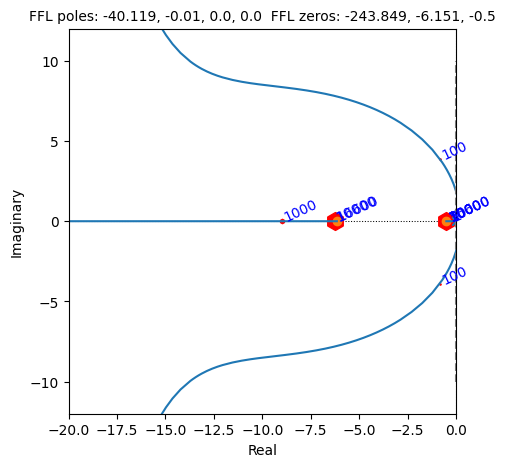

In [27]:
rIP = 6
rDP = 0.004
PID_tf = (rIP + s + rDP*s**2)/s
ff_tf = PID_tf*QS_TF
_ = plotRootLocusWithGains(ff_tf, [1, 5, 10, 100,1000,10000, 16600], xlim=[-20,0],ylim=[-12,12],markersize_multiplier=0.01)

# Step 5. Construct a final design using a testbed (15 pt)

The theory-based design provides a starting point for your final design that is based on a test-bed as you did in Homework 1. Use intutitions from the root locus plot to adjust the values of design parameters.

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


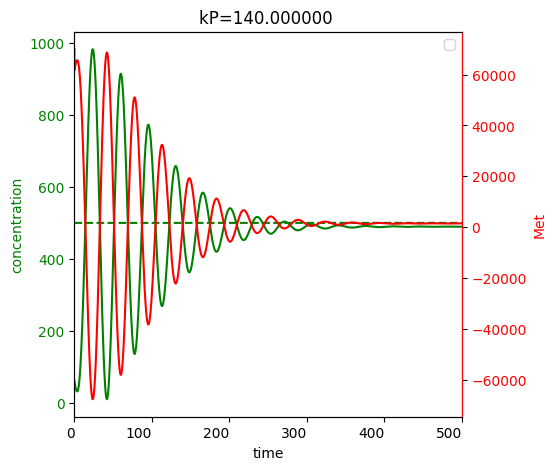

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.10it/s]


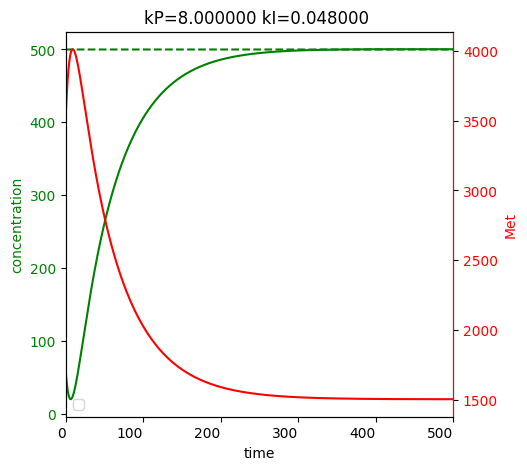

In [28]:
kP=8
rIP=0.006
rDP=0.0033
_=QS_CTLSB.plotDesign(setpoint=500, kP_spec=140, kI_spec=0, kD_spec=0,times=np.linspace(0,500,5000))
_=QS_CTLSB.plotDesign(setpoint=500, kP_spec=kP, kI_spec=rIP*kP, kD_spec=0,times=np.linspace(0,500,5000))
#_=QS_CTLSB.plotDesign(setpoint=500, kP_spec=100, kI_spec=0, kD_spec=0,times=np.linspace(1000, 10000, 10000))

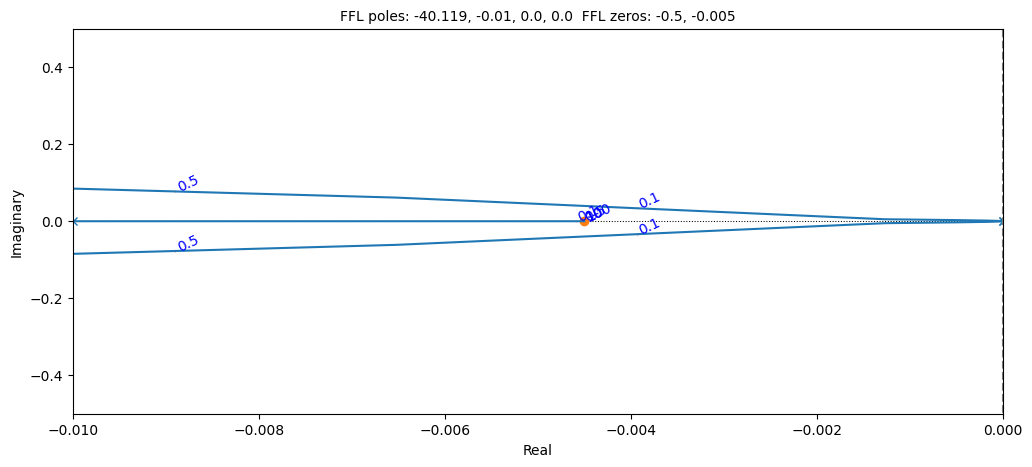

In [29]:
#putting the zero too close to the open loop pole yields major noise at early timepoints. why?
rIP = 0.0045
PI_tf = control.TransferFunction([1, rIP], [1, 0])
_ = plotRootLocusWithGains(PI_tf*QS_TF, gains=[0.1, 0.5, 1, 10,100], xlim=[-0.01, 0], ylim=[-0.5, 0.5], figsize=(12, 5),markersize_multiplier=0.1)

# Step 6. Evaluate the final design (5 pt)

Answer the following questions:
1. Did you need to change your system objectives? At what points did you did you do this?
2. What criteria did you use to determine that your system identification was sufficient?
3. How close was your theory-based design to the testbed-based design that you chose.